In [35]:
# Import array, visualisation and database modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import variable assessment modules
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import rogistic regression processing modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Import Random Forest related modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV


In [3]:
# Read database from csv
try:
    df_telco = pd.read_csv('Telco-Customer-Churn.csv')
except FileNotFound as error:
    print(error)

DATA INSPECTION

In [4]:
def clean_data(df, convert_to_num1, convert_to_num2, num_label, num_label_new, categoricals):
    ''' Receives a dataframe and removes duplicates, convertes requested fields to numeric,
        creates dummie fields, performs labelling for requested boolean field
        Args: 
            df(dataframe): The dataframe containing the data.
            convert_to_num1(str): Column name to be converted.
            convert_to_num2(str): Column name to be converted.
            num_label(str): Column name for label encoding.
            num_label_new(str): New Column name after encoding. 
        Returns dataframe
        '''
    df = df.copy()
    df = df.drop_duplicates(subset=None, keep='first', inplace=False)
    try:
        rows = len(df)
        df[convert_to_num1] = pd.to_numeric(df[convert_to_num1], errors='coerce')
        print(f'Total null count {convert_to_num1}: {df[convert_to_num1].isna().sum()}\n'
              f'Percentage null: {round((df[convert_to_num1].isna().sum()/rows)*100,2)}%')
        df[convert_to_num2] = pd.to_numeric(df[convert_to_num2], errors='coerce')
        print(f'Total null count {convert_to_num2}: {df[convert_to_num2].isna().sum()}\n'
              f'Percentage null: {round((df[convert_to_num2].isna().sum()/rows)*100,2)}%')
        df = df.dropna()
        print("Rows containing empty fields dropped.")
    except ValueError as error:
        print('non-numeric values present: could not convert')
        print(error)
    try:
        df[num_label_new] = np.where(df[num_label] == "Yes", 1, 0)
        print(f'{num_label} was converted. Yes = 1, No = 0')
    except ValueError as error:
        print("Unable to convert to numbers.")
        print(error)
    try:
        df_dummies = pd.get_dummies(df, columns = categoricals, drop_first=True)
        print('Dummies created.')
    except ValueError as error:
        print('Unable to convert to dummies.')
        print(error)
    return df_dummies

In [5]:
def dis_corr(dict_item, title):
    ''' Displays correlations
    Args: 
        Dictionary containing name of field and its correlating fields.
        Title of the display.
    '''
    print(f'{title.upper()}\n')
    
    for key, values in dict_item.items():
        string = ', '.join(values)
        print(f' {key}: {string}')
        print('')
    print('')

In [6]:
def check_for_cor(corr_table):
    '''Receives a correlarion table and identifies fields with mod - very strong
       correlations.
       Creates disctionaries of the Moderate correlations, strong correlations
       and very strong correlations.
       Displays the dictionaries
    '''
    corr_table = corr_table.abs()
    mod_corr = {}
    strong_corr = {}
    very_strong_corr = {}
    for index, row in corr_table.iterrows():
        for col in corr_table.columns:
            if index == col:
                continue
            elif row[col] >= 0.4 and row[col] <= 0.59:
                mod_corr.setdefault(index, []).append(col)
            elif row[col] >= 0.6 and row[col] <= 0.79:
                strong_corr.setdefault(index, []).append(col)
            elif row[col] >= 0.8 and row[col] <= 1.00:
                very_strong_corr.setdefault(index, []).append(col)
            else:
                continue
    dis_corr(very_strong_corr, 'VERY STRONG CORRELATIONS (>=0.8):\n')
    dis_corr(strong_corr, 'STRONG CORRELATIONS (0.6-0.79):\n')
    dis_corr(mod_corr, 'MODERATE CORRELATIONS (0.4-0.49):\n')

In [29]:
def get_drop_list(series, exclude_fields=[]):
    '''Receives a series of VIF datapoints with corresponding fields
       and fields to exclude from list.   
       Makes a list of suggested fields to drop based on high multicollinearity
    '''
    drop_list = []
    for feature, vif in series.items():
        if vif > 1000:
            drop_list.append(feature)
        else:
            continue
    if exclude_fields != []:
        for field in exclude_fields:
            if field in drop_list:
                drop_list.remove(field)
            else:
                print(f'{field} could not be excluded as it was not'
                      ' found in the droplist')
    return drop_list

In [8]:
def calc_vif(df):
    '''Receives a dataframe and calculates the variance inflation factor.
    Returns a series'''
    X = add_constant(df)
    vif_data = pd.DataFrame()
    try:
        vif_data['feature'] = df.columns
        series = pd.Series([variance_inflation_factor(X.values, i)
                      for i in range(X.shape[1])], index = X.columns)
        return (series)
    except ValueError as error:
        print ('Could not calculate ViF: invalid field datatype(s)')
        print(error)

FUNCTIONS: DATA VISUALISATION 

In [9]:
def scatter(df, field1, field2):
    ''' Receives a dataframe and 2 fields to plot a scatterplot'''
    plt.scatter(df[field1], df[field2], alpha=0.5)
    plt.title(f'{field1} vs {field2}')
    plt.xlabel(field1)
    plt.ylabel(field2)
    plt.show()

In [10]:
def histo(df, field, title, x_title, y_title='Count'):
    '''receives a dataframe, field, title for the chart, x-axis title,
    y-axis title (defaults to count) and plots a histogram'''    
    sns.histplot(df[field], bins=20, kde=True, edgecolor='black')
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.show()

In [11]:
def compare_box_same(df, column_variable, column_grouping, 
                     title_variable, title_grouping, title):
    '''
    Receives dataframe, 2 column references and 2 titles 
    Plots 2 side by side box-plots with the same axes (intervals)
    '''
    df_box = df[[column_variable, column_grouping]]
    
    sns.boxplot(data=df_box, x=column_grouping, y=column_variable)
    plt.xlabel(column_grouping)
    plt.ylabel(column_variable)
    plt.title(title)
    plt.show()

In [12]:
def display_confusion(y_test, y_pred, title):
    '''Receives the y_test values and predicted y_values
    constructs and displays a confusion matrix prints and returns 
    a dictionary holding the Negativity and Positivity rates for the model.
    '''
    results = {'True Negative': 0,
               'False Positive': 0,
               'False Negative': 0,
               'True Positive': 0}
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', xticks_rotation='horizontal')
    plt.title(title)
    results['True Negative'] = cm[0,0]
    results['False Positive'] = cm[0,1]
    results['False Negative'] = cm[1,0]
    results['True Positive'] = cm[1,1]
    for key, item in results.items():
        print(key, item)
    return results

FUNCTIONS: MACHINE LEARNING MODELS

In [13]:
def test_model(model, X_test, y_test):
    '''Receives a fitted model and the test values. 
    Calculates the performance scores, prints them and 
    returns a dictionary with the scores for the model
    '''    
    scores = {'Accuracy' : 0,
              'Precision' : 0, 
              'Recall' : 0, 
              'F1': 0,
             }
    y_pred = model.predict(X_test)
    scores['Accuracy'] = accuracy_score(y_test, y_pred)
    scores['Precision'] = precision_score(y_test, y_pred)
    scores['Recall'] = recall_score(y_test, y_pred)
    scores['F1'] = f1_score(y_test, y_pred)

    for key, score in scores.items():
        print(f'{key}: {score}')
    return scores, y_pred

In [27]:
def corr_matrix(df):
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True)
    plt.show()

In [376]:
df_telco.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [15]:
df_telco.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [16]:
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [17]:
df_telco.shape

(7043, 21)

In [18]:
# view all unique entries
for field in df_telco.columns:
    print(f'\n{field}')
    print(df_telco[field].unique())


customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender
['Female' 'Male']

SeniorCitizen
[0 1]

Partner
['Yes' 'No']

Dependents
['No' 'Yes']

tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

PhoneService
['No' 'Yes']

MultipleLines
['No phone service' 'No' 'Yes']

InternetService
['DSL' 'Fiber optic' 'No']

OnlineSecurity
['No' 'Yes' 'No internet service']

OnlineBackup
['Yes' 'No' 'No internet service']

DeviceProtection
['No' 'Yes' 'No internet service']

TechSupport
['No' 'Yes' 'No internet service']

StreamingTV
['No' 'Yes' 'No internet service']

StreamingMovies
['No' 'Yes' 'No internet service']

Contract
['Month-to-month' 'One year' 'Two year']

PaperlessBilling
['Yes' 'No']

PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)

In [19]:
# Identify categorical fields with one-hot coding
categoricals = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'
               ]
# Drop unneccesary fields
df_telco = df_telco.drop('customerID', axis=1)

# Call cleaning function
telecom_cust_dummies = clean_data(df_telco,'MonthlyCharges','TotalCharges', 'Churn', 'Churn_bin', categoricals)

Total null count MonthlyCharges: 0
Percentage null: 0.0%
Total null count TotalCharges: 11
Percentage null: 0.16%
Rows containing empty fields dropped.
Churn was converted. Yes = 1, No = 0
Dummies created.


In [20]:
telecom_cust_dummies.head()

,tenure,MonthlyCharges,TotalCharges,Churn,Churn_bin,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,No,0,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
1,34,56.95,1889.50,No,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,2,53.85,108.15,Yes,1,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,True
3,45,42.30,1840.75,No,0,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,2,70.70,151.65,Yes,1,False,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False


In [21]:
# Drop unneeded fields
if 'Churn' in telecom_cust_dummies.columns:
    telecom_cust_dummies = telecom_cust_dummies.drop(['Churn'], axis=1)

In [22]:
telecom_cust_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7010 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7010 non-null   int64  
 1   MonthlyCharges                         7010 non-null   float64
 2   TotalCharges                           7010 non-null   float64
 3   Churn_bin                              7010 non-null   int64  
 4   gender_Male                            7010 non-null   bool   
 5   SeniorCitizen_1                        7010 non-null   bool   
 6   Partner_Yes                            7010 non-null   bool   
 7   Dependents_Yes                         7010 non-null   bool   
 8   PhoneService_Yes                       7010 non-null   bool   
 9   MultipleLines_No phone service         7010 non-null   bool   
 10  MultipleLines_Yes                      7010 non-null   bool   
 11  InternetS

In [23]:
bool_cols = telecom_cust_dummies.select_dtypes('bool').columns  
# I used ChatGPT to find a way to find the bool cols 
telecom_cust_dummies[bool_cols] = telecom_cust_dummies[bool_cols].astype(int)

In [24]:
dummy_counts = telecom_cust_dummies.sum()
print(dummy_counts)

tenure                                     227968.00
MonthlyCharges                             454869.55
TotalCharges                             16055377.25
Churn_bin                                    1857.00
gender_Male                                  3535.00
SeniorCitizen_1                              1141.00
Partner_Yes                                  3393.00
Dependents_Yes                               2099.00
PhoneService_Yes                             6330.00
MultipleLines_No phone service                680.00
MultipleLines_Yes                            2967.00
InternetService_Fiber optic                  3090.00
InternetService_No                           1506.00
OnlineSecurity_No internet service           1506.00
OnlineSecurity_Yes                           2015.00
OnlineBackup_No internet service             1506.00
OnlineBackup_Yes                             2425.00
DeviceProtection_No internet service         1506.00
DeviceProtection_Yes                         2

In [25]:
# Create a correlation table and display 2 tables
corr_table = telecom_cust_dummies.corr()
corr_table_sort = corr_table.sort_values(by = "Churn_bin", ascending=False)
corr_table_sort


,tenure,MonthlyCharges,TotalCharges,Churn_bin,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
Churn_bin,-0.353339,0.194008,-0.198362,1.000000,-0.008694,0.151270,-0.148670,-0.162366,0.011072,-0.011072,...,-0.228220,0.065058,-0.228220,0.062670,-0.177742,-0.301375,0.190518,-0.134052,0.301079,-0.091649
InternetService_Fiber optic,0.016640,0.787169,0.360768,0.307612,-0.009898,0.254556,0.000212,-0.165140,0.290997,-0.290997,...,-0.464418,0.329704,-0.464418,0.322398,-0.077498,-0.210967,0.325295,-0.051204,0.334537,-0.304077
PaymentMethod_Electronic check,-0.211583,0.269931,-0.061060,0.301079,0.001452,0.170949,-0.083856,-0.149862,0.002890,-0.002890,...,-0.282854,0.144760,-0.282854,0.137415,-0.109966,-0.281924,0.207569,-0.374894,1.000000,-0.385422
MonthlyCharges,0.244194,1.000000,0.650540,0.194008,-0.012361,0.219131,0.095277,-0.114641,0.249625,-0.249625,...,-0.762181,0.629336,-0.762181,0.626885,0.003271,-0.075152,0.350900,0.028552,0.269931,-0.373324
PaperlessBilling_Yes,0.003709,0.350900,0.157449,0.190518,-0.011497,0.155922,-0.014856,-0.110973,0.017017,-0.017017,...,-0.319082,0.224151,-0.319082,0.211456,-0.052846,-0.147104,1.000000,-0.014221,0.207569,-0.202521
SeniorCitizen_1,0.014456,0.219131,0.101642,0.151270,-0.001069,1.000000,0.016030,-0.211479,0.008724,-0.008724,...,-0.181713,0.104830,-0.181713,0.119247,-0.047053,-0.116898,0.155922,-0.024909,0.170949,-0.151840
StreamingTV_Yes,0.278077,0.629336,0.514548,0.065058,-0.006488,0.104830,0.122387,-0.018146,-0.020595,0.020595,...,-0.414390,1.000000,-0.414390,0.532456,0.060738,0.070836,0.224151,0.038762,0.144760,-0.245983
StreamingMovies_Yes,0.283212,0.626885,0.518704,0.062670,-0.009471,0.119247,0.115979,-0.040073,-0.032697,0.032697,...,-0.417891,0.532456,-0.417891,1.000000,0.063583,0.074310,0.211456,0.047152,0.137415,-0.248553
MultipleLines_Yes,0.330194,0.490016,0.467641,0.041888,-0.008199,0.142403,0.140338,-0.026103,0.280776,-0.280776,...,-0.209085,0.256229,-0.209085,0.257610,-0.004982,0.105286,0.163462,0.059004,0.083436,-0.225640
PhoneService_Yes,0.009217,0.249625,0.114222,0.011072,-0.007799,0.008724,0.019420,-0.000408,1.000000,-1.000000,...,0.171445,-0.020595,0.171445,-0.032697,-0.002615,0.005022,0.017017,-0.006381,0.002890,-0.005708


In [388]:
# Display table sorted according to absolute values to identify the strongest correlations
corr_table_abs_sort= corr_table.abs().sort_values(by = "Churn_bin", ascending=False)
corr_table_abs_sort

,tenure,MonthlyCharges,TotalCharges,Churn_bin,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
Churn_bin,0.353339,0.194008,0.198362,1.000000,0.008694,0.151270,0.148670,0.162366,0.011072,0.011072,...,0.228220,0.065058,0.228220,0.062670,0.177742,0.301375,0.190518,0.134052,0.301079,0.091649
tenure,1.000000,0.244194,0.825293,0.353339,0.006370,0.014456,0.379564,0.161288,0.009217,0.009217,...,0.033641,0.278077,0.033641,0.283212,0.200872,0.563273,0.003709,0.231385,0.211583,0.228902
InternetService_Fiber optic,0.016640,0.787169,0.360768,0.307612,0.009898,0.254556,0.000212,0.165140,0.290997,0.290997,...,0.464418,0.329704,0.464418,0.322398,0.077498,0.210967,0.325295,0.051204,0.334537,0.304077
Contract_Two year,0.563273,0.075152,0.357016,0.301375,0.003146,0.116898,0.246114,0.200783,0.005022,0.005022,...,0.220282,0.070836,0.220282,0.074310,0.290013,1.000000,0.147104,0.173645,0.281924,0.005351
PaymentMethod_Electronic check,0.211583,0.269931,0.061060,0.301079,0.001452,0.170949,0.083856,0.149862,0.002890,0.002890,...,0.282854,0.144760,0.282854,0.137415,0.109966,0.281924,0.207569,0.374894,1.000000,0.385422
InternetService_No,0.033641,0.762181,0.373655,0.228220,0.003164,0.181713,0.002823,0.141100,0.171445,0.171445,...,1.000000,0.414390,1.000000,0.417891,0.039877,0.220282,0.319082,0.003568,0.282854,0.315183
OnlineSecurity_No internet service,0.033641,0.762181,0.373655,0.228220,0.003164,0.181713,0.002823,0.141100,0.171445,0.171445,...,1.000000,0.414390,1.000000,0.417891,0.039877,0.220282,0.319082,0.003568,0.282854,0.315183
DeviceProtection_No internet service,0.033641,0.762181,0.373655,0.228220,0.003164,0.181713,0.002823,0.141100,0.171445,0.171445,...,1.000000,0.414390,1.000000,0.417891,0.039877,0.220282,0.319082,0.003568,0.282854,0.315183
TechSupport_No internet service,0.033641,0.762181,0.373655,0.228220,0.003164,0.181713,0.002823,0.141100,0.171445,0.171445,...,1.000000,0.414390,1.000000,0.417891,0.039877,0.220282,0.319082,0.003568,0.282854,0.315183
StreamingMovies_No internet service,0.033641,0.762181,0.373655,0.228220,0.003164,0.181713,0.002823,0.141100,0.171445,0.171445,...,1.000000,0.414390,1.000000,0.417891,0.039877,0.220282,0.319082,0.003568,0.282854,0.315183


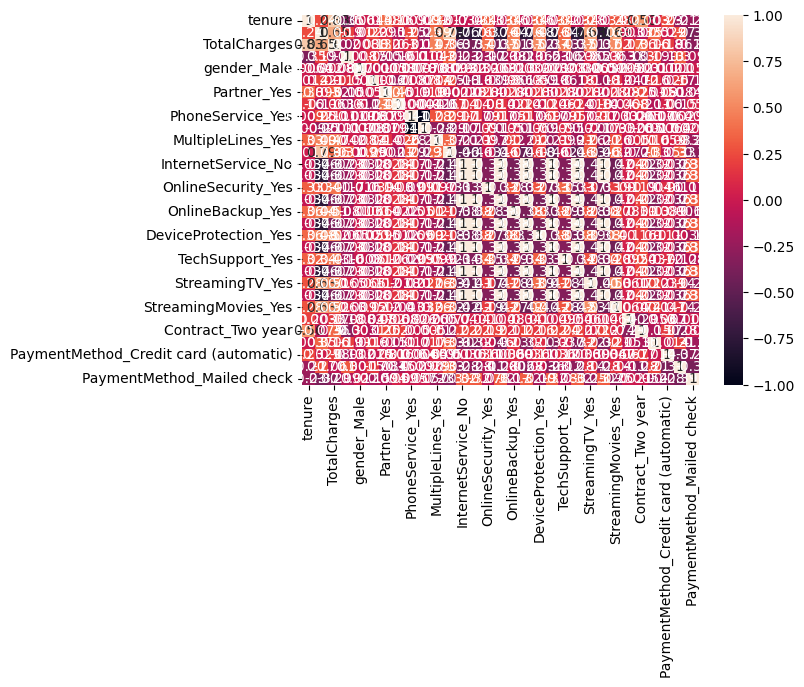

In [28]:
corr_matrix(telecom_cust_dummies)

In [389]:
# Call the function that splits fields into different strengths of correlation
check_for_cor(corr_table)

VERY STRONG CORRELATIONS (>=0.8):


 tenure: TotalCharges

 TotalCharges: tenure

 InternetService_No: OnlineSecurity_No internet service, OnlineBackup_No internet service, DeviceProtection_No internet service, TechSupport_No internet service, StreamingTV_No internet service, StreamingMovies_No internet service

 OnlineSecurity_No internet service: InternetService_No, OnlineBackup_No internet service, DeviceProtection_No internet service, TechSupport_No internet service, StreamingTV_No internet service, StreamingMovies_No internet service

 OnlineBackup_No internet service: InternetService_No, OnlineSecurity_No internet service, DeviceProtection_No internet service, TechSupport_No internet service, StreamingTV_No internet service, StreamingMovies_No internet service

 DeviceProtection_No internet service: InternetService_No, OnlineSecurity_No internet service, OnlineBackup_No internet service, TechSupport_No internet service, StreamingTV_No internet service, StreamingMovies_No internet

In [31]:
# Calculate teh Variance inflation factors
vif_series = calc_vif(telecom_cust_dummies)
vif_series

C:\Users\Anton\Desktop\Datascience US Certificate\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Anton\Desktop\Datascience US Certificate\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


const                                      0.000000
tenure                                     7.591110
MonthlyCharges                           862.553118
TotalCharges                              10.902911
Churn_bin                                  1.395789
gender_Male                                1.002097
SeniorCitizen_1                            1.154971
Partner_Yes                                1.459073
Dependents_Yes                             1.381293
PhoneService_Yes                                inf
MultipleLines_No phone service                  inf
MultipleLines_Yes                          7.283102
InternetService_Fiber optic              148.241163
InternetService_No                              inf
OnlineSecurity_No internet service              inf
OnlineSecurity_Yes                         6.335734
OnlineBackup_No internet service                inf
OnlineBackup_Yes                           6.788325
DeviceProtection_No internet service            inf
DeviceProtec

In [32]:
# Call function that suggests the list of fields to drop that have VIF > 1000
drop_list = get_drop_list(vif_series, ['Churn_bin'])
print(drop_list)

Churn_bin could not be excluded as it was not found in the droplist
['PhoneService_Yes', 'MultipleLines_No phone service', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']


In [33]:
# Drop suggested fields
df_clean_telco = telecom_cust_dummies.drop(columns=drop_list)
df_clean_telco.head()

,tenure,MonthlyCharges,TotalCharges,Churn_bin,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,0,1,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4,2,70.70,151.65,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


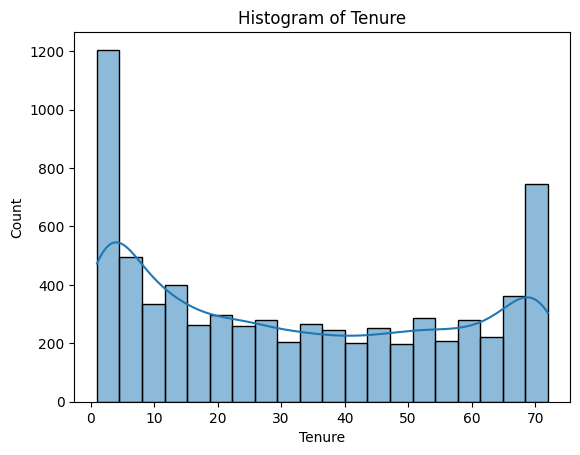

In [36]:
# Display distribution of Tenure
histo(df_clean_telco,'tenure', 'Histogram of Tenure', 'Tenure')

Abnormal distribution noted

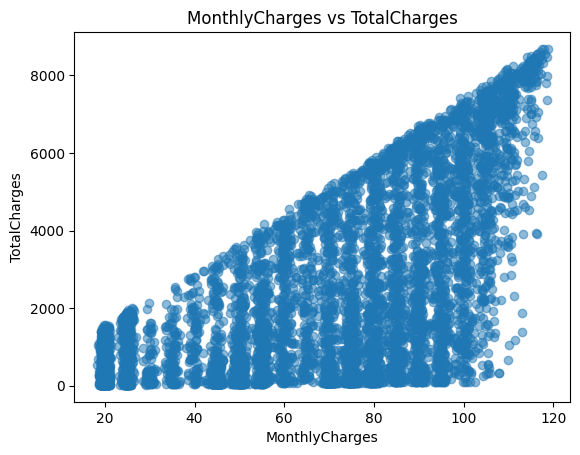

In [37]:
# View relationship between Monthly charges and Total Charges
scatter(telecom_cust_dummies, "MonthlyCharges", "TotalCharges")

Very Strong Correlation as previously noted

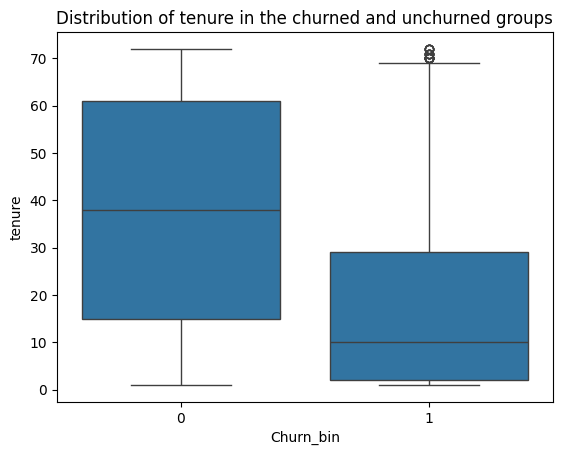

In [394]:
# Compare tenure of churned and unchurned groups
compare_box_same(df_clean_telco, "tenure", "Churn_bin", "Tenure", "Churned(1) or not(0)", "Distribution of tenure in the churned and unchurned groups")

In [52]:
# Combine features
df_clean_telco['Charges'] = df_clean_telco['MonthlyCharges'] + df_clean_telco['TotalCharges']
df_clean_telco = df_clean_telco.drop(columns = ['MonthlyCharges', 'TotalCharges'])

In [53]:
# Recalculate thh Variance inflation factors
vif_series = calc_vif(df_clean_telco)
vif_series

const                                    15.142690
tenure                                    7.083036
Churn_bin                                 1.378739
gender_Male                               1.001661
SeniorCitizen_1                           1.151122
Partner_Yes                               1.458571
Dependents_Yes                            1.379845
MultipleLines_Yes                         1.398555
InternetService_Fiber optic               2.294587
OnlineSecurity_Yes                        1.352263
OnlineBackup_Yes                          1.416092
DeviceProtection_Yes                      1.494833
TechSupport_Yes                           1.443260
StreamingTV_Yes                           1.709332
StreamingMovies_Yes                       1.717931
Contract_One year                         1.583563
Contract_Two year                         2.478479
PaperlessBilling_Yes                      1.196746
PaymentMethod_Credit card (automatic)     1.559594
PaymentMethod_Electronic check 

The median of tenure was much shorter(10 vs 38) in the Churned group.

In [54]:
## Machine learning preparation
features = df_clean_telco.columns.drop('Churn_bin')
print(features)
# Select features columns
X = df_clean_telco[features].values

# Slect dependant variable 
y = df_clean_telco['Churn_bin'].values


Index(['tenure', 'gender_Male', 'SeniorCitizen_1', 'Partner_Yes',
       'Dependents_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Charges'],
      dtype='object')


In [55]:
# Normalisation

# Initialise scaler
sc = MinMaxScaler()

# Fit and transform feature X and dependant y
X = sc.fit_transform(X)


In [56]:
# Random state definition
r = 42

In [57]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                   random_state=r)

In [58]:
# Initialise and fit a logistic regression model
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [59]:
get_scores_log_reg, y_pred = test_model(log_reg_model, X_test, y_test)


Accuracy: 0.8111808328579578
Precision: 0.6550724637681159
Recall: 0.5159817351598174
F1: 0.5772669220945083


In [60]:
# Create a Random Forest Model
rf = RandomForestClassifier(random_state=r)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [61]:
# Determine accuracy
get_scores_rf, y_pred_rf = test_model(rf, X_test, y_test)

Accuracy: 0.7906446092413006
Precision: 0.6047197640117994
Recall: 0.4680365296803653
F1: 0.5276705276705277


In [62]:
importances = rf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': features, 'Gini Importance'
                              :importances}).sort_values('Gini Importance',
                                                         ascending=False)
feature_imp_df

,Feature,Gini Importance
19,Charges,0.258444
0,tenure,0.208492
6,InternetService_Fiber optic,0.065181
17,PaymentMethod_Electronic check,0.042387
14,Contract_Two year,0.035290
1,gender_Male,0.034138
15,PaperlessBilling_Yes,0.033475
5,MultipleLines_Yes,0.028721
3,Partner_Yes,0.028332
8,OnlineBackup_Yes,0.027386


In [63]:
# Tune hyperparameter fo a new RF model
rf_hp = RandomForestClassifier(n_estimators=2000, max_features='sqrt',
                               max_leaf_nodes=50, bootstrap=True, oob_score=True)
rf_hp.fit(X_train, y_train)

,n_estimators,2000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,50
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [64]:
# test model
get_scores_rf_hp, y_pred_rf_hp = test_model(rf_hp, X_test, y_test)

Accuracy: 0.8163148887621221
Precision: 0.7013888888888888
Recall: 0.4611872146118721
F1: 0.5564738292011019


In [65]:
oob_est = 1-rf_hp.oob_score_
print(f'OOB error rate: {oob_est}')

OOB error rate: 0.20258702682138097


20% of internal validation samples were misclassified

True Negative 1196
False Positive 119
False Negative 212
True Positive 226


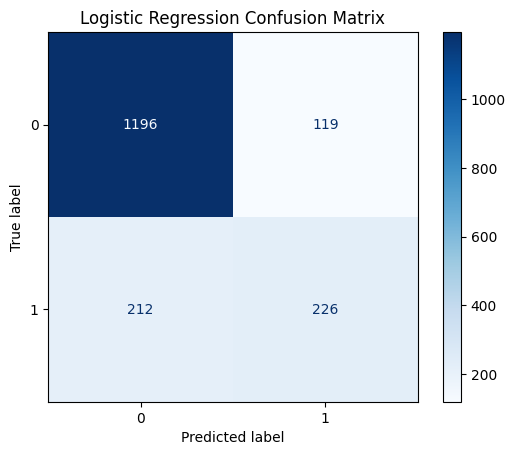

In [66]:
# Create Confusion matrices for the models
log_reg_results = display_confusion(y_test, y_pred, "Logistic Regression Confusion Matrix")

True Negative 1181
False Positive 134
False Negative 233
True Positive 205


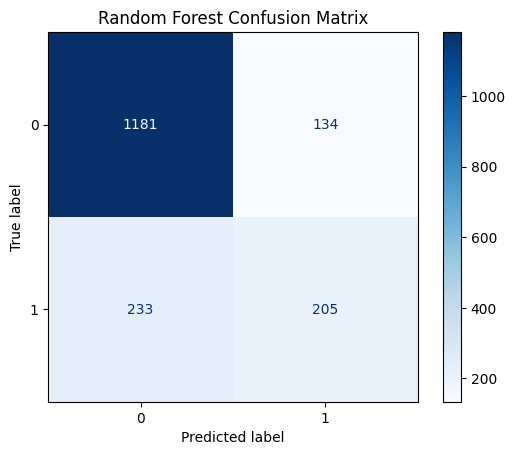

In [67]:
random_forest_results = display_confusion(y_test, y_pred_rf, "Random Forest Confusion Matrix")

True Negative 1229
False Positive 86
False Negative 236
True Positive 202


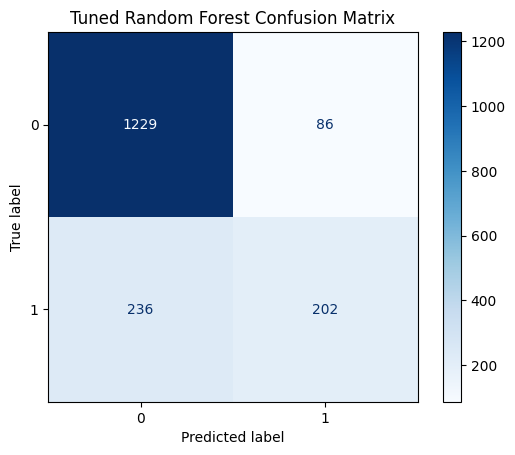

In [69]:
tuned_forest_results = display_confusion(y_test, y_pred_rf_hp, 'Tuned Random Forest Confusion Matrix')

In [70]:
# Summarise results of confusion tables
df_results = pd.DataFrame([log_reg_results, random_forest_results, tuned_forest_results], 
                          index = ['Logistic Regression', 'Random Forest', 'Tuned Random Forest'])

print(df_results)

                     True Negative  False Positive  False Negative  \
Logistic Regression           1196             119             212   
Random Forest                 1181             134             233   
Tuned Random Forest           1229              86             236   

                     True Positive  
Logistic Regression            226  
Random Forest                  205  
Tuned Random Forest            202  


Based on these results we can see that the Logistic regression model most accurately identified the individuals that truly churned (highest true positive and lowest fasle negative), but the Tuned Random Forest model had the lowest false positives and highest true negatives (most accurate identified those that did not churn)

In [71]:
# Display model performances in user-friendly manner for comparison
df_scores = df_results = pd.DataFrame([get_scores_log_reg, get_scores_rf, get_scores_rf_hp], 
                          index = ['Logistic Regression', 'Random Forest', 'Tuned Random Forest'])
print(df_scores)

                     Accuracy  Precision    Recall        F1
Logistic Regression  0.811181   0.655072  0.515982  0.577267
Random Forest        0.790645   0.604720  0.468037  0.527671
Tuned Random Forest  0.816315   0.701389  0.461187  0.556474


Overall the Tuned Random Forest and Logistic Regression Models showed the similar accuracy, but the logistic regression model showed higher recall and F1 score making it the strongest overall model, making it the best model to identify people that might churn (although it may idenitify some people as churners when they are in fact not). 

The tuned random forest model showed the highest precision with the lowest false positive rate. This model would fail to identify some churners but would less likely falsely identify churners. 

In conclusion: The logistic regression model is the most balanced. If a model that identifies most churners is needed this is the best model. 
    If the aim is to focus more attention on these clients to prevent churning it may result in overspending (as it may falsely identify some people as churners). 
    If overspending is a concern then the Tuned Random Forest model might be better where focus is placed only on those most likely to churn (although some potential churners would be missed).